### María Sofía Álvarez - Brenda Barahona - Álvaro Plata
<h1 align='center'>Proyecto 1: Analítica de textos - Modelo X</h1>

In [ ]:
#!pip install imblearn

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import precision_score, make_scorer
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Lo primero que hacemos es cargar los datasets que fueron creados en el notebook de preprocesamiento:

In [2]:
datos_train = pd.read_csv('train_Data.csv')
datos_test = pd.read_csv('test_Data.csv')
datos_train.sample(5)

,Unnamed: 0,problems_described,tokenized_abstracts,non_tokenized_abstracts,non_tokenized_entities,tokenized_entities
8950,372,4,"['amilorid', 'block', 'onset', 'acthinduc', 'h...",amilorid block onset acthinduc hypertens sheep...,amilorid acthinduc amilorid frusemid acth amil...,"['amilorid', 'acthinduc', 'amilorid', 'frusemi..."
1335,5417,5,"['trial', 'brief', 'intermitt', 'neurolept', '...",trial brief intermitt neurolept prophylaxi sel...,depot oral depot depot oral depot,"['depot', 'oral', 'depot', 'depot', 'oral', 'd..."
2557,11669,3,"['respiratori', 'muscl', 'involv', 'nemalin', ...",respiratori muscl involv nemalin myopathi boy ...,respiratori muscl boy muscl muscl biopsi respi...,"['respiratori', 'muscl', 'boy', 'muscl', 'musc..."
5373,2163,2,"['incontin', 'rectal', 'prolaps', 'prospect', ...",incontin rectal prolaps prospect manometr pros...,rectal rectal rectal anal anal anorect anorect...,"['rectal', 'rectal', 'rectal', 'anal', 'anal',..."
1546,4745,1,"['pneumocysti', 'carinii', 'pneumonia', 'prima...",pneumocysti carinii pneumonia primari brain tu...,brain tumor pneumocysti carinii brain tumor ca...,"['brain', 'tumor', 'pneumocysti', 'carinii', '..."


In [3]:
abstracts = datos_train['tokenized_abstracts']
entities = datos_train['tokenized_entities']
Y_train = datos_train['problems_described']

# TO DO: Describir el algoritmo X que van a utilizar

In [59]:
# Definimos la metrica
custom_scorer = make_scorer(precision_score, greater_is_better=True,  average='micro')

## Continuación del preprocesamiento
Ahora, debemos definir la vectorización que se utilizará para los textos. De acuerdo a lo visto en el anterior notebook, para este algoritmo podemos utilizar TF-iDF o un Count-Vectorizer. Así las cosas, usaremos el primero para el modelo que se entrenará con medical abstracts y, el segundo, sobre el modelo que se entrenará sobre las entidades médicas obtenidas. En este último caso usamos Count-Vectorizer porque algunas palabras clave se repiten y podría ser perjudicial si se usa TF-iDF, ya que este algoritmo se basa en frecuencias.

Las dos primeras pipelines se aplican sobre los medical abstracts mientras que, las dos siguientes, sobre las entidades médicas.
### Pipeline 1: Vectorización con TF-iDF y undersampling.

Para el proceso de vectorizar las entradas decidimos simplificar las opciones, limitando a que el modelo reciba tokens de palabras individuales (posteriormente algunos modelos podrán explorar 2-gramas o 3-gramas, dependiendo de las posibilidades computacionales). Por lo tanto se escogió TF-iDF para este paso. Las motivaciones detrás de esta elección son variadas. Lo primero es su notable superioridad ante modelos como bag-of-words que no tienen en cuenta la importancia relativa de una palabra dentro del corpus. TF-iDF además se comporta muy bien con las familias de modelos que exploraremos para este problema, como Naïve Bayes, según muestran Cahyani et al. [2].

Asimismo, intentamos hacer undersampling de los datos que tenemos, usando técnicas de la librería <code>imblearn</code>. En este caso, usaremos la técnica <code>EditedNearestNeighbors</code>, el cual aplica un algoritmo de KNN (por defecto, 3) y edita el conjunto de datos al remover las muestras que no están lo suficientemente de acuerdo con su vecindario. Para cada muestra de la clase a la que se le aplicará undersampling, se computan los vecinos más cercanos y si el criterio de selección no se cumple, la muestra se elimina. En este caso, el número de vecinos sería un hiperparámetro, pero consideramos más importante ajustar los del algoritmo per se que utilizaremos.

In [37]:
tfidf_subsampling_pipe = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ("sampling", EditedNearestNeighbours()),
    ("algorithm", MultinomialNB())
])
tfidf_subsampling_pipe

Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                ('sampling', EditedNearestNeighbours()),
                ('algorithm', MultinomialNB())])

In [50]:
param_grid = {"algorithm__alpha": [0.05, 0.5, 1],
              "algorithm__fit_prior": (True, False),
             "tf_idf_vec__ngram_range": [(1,1),(1,2),(1,3)]}

In [60]:
tfidf_subsampling_model = GridSearchCV(estimator = tfidf_subsampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [61]:
tfidf_subsampling_model.fit(abstracts, Y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.399 total time=   2.3s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.414 total time=   2.2s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.297 total time=   5.8s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.345 total time=   5.7s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.298 total time=  10.9s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.332 total time=  10.5s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, tf_idf_vec__ngram_range=(1, 1);, score=0.458 total time=   2.2s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fi

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                                       ('sampling', EditedNearestNeighbours()),
                                       ('algorithm', MultinomialNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'tf_idf_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [62]:
#Para imprimir los mejores parametros:
tfidf_subsampling_model.best_params_

{'algorithm__alpha': 0.05,
 'algorithm__fit_prior': False,
 'tf_idf_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 1
               precision    recall  f1-score   support

           1       0.68      0.75      0.71      2103
           2       0.33      0.98      0.49       994
           3       0.68      0.30      0.42      1280
           4       0.62      0.81      0.70      2029
           5       0.68      0.24      0.36      3194

    accuracy                           0.56      9600
   macro avg       0.60      0.62      0.54      9600
weighted avg       0.63      0.56      0.53      9600



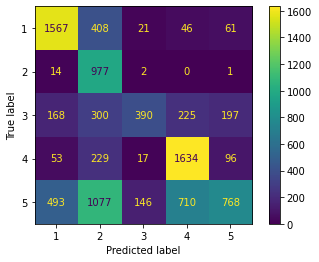

In [81]:
y_pred_tfidf_subsampling = tfidf_subsampling_model.predict(abstracts)
report_pipe_p1 = classification_report(Y_train, y_pred_tfidf_subsampling)
print("Test Report for Multinomial NB Pipe 1\n", report_pipe_p1)
cm = confusion_matrix(Y_train, y_pred_tfidf_subsampling)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= tfidf_subsampling_model.classes_)
disp.plot()

# TO DO: Comentar el resultado

### Pipeline 2: Vectorización con TF-iDF y oversampling (+ reducción de dimensionalidad)

Usaremos TF-iDF también en este caso, pero en lugar de hacer undersampling, utilizaremos un algoritmo de oversampling. En este caso, utilizaremos una variación de SMOTE, denominada SMOTEENN para evitar generar muestras ruidosas [6]. Este algoritmo, en realidad, usa una mezcla de under y oversampling.

Finalmente, como aplicamos esta pipeline sobre los textos médicos (y no sobre las entidades extraídas), conviene hacer reducción de dimensionalidad. En este caso, utilizaremos PCA <font color='red'>buscar qué hace PCA muy resumidamente</font> y mantendremos el 95% de la varianza de las componentes, lo que nos da una buena probabilidad de que los features elegidos no sean independientes de la variable objetivo. Así,

In [ ]:
tfidf_oversampling_pipe = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ("sampling", SMOTEENN(random_state=28)),
    ("dim_red", PCA(n_components=0.95)),
    ("algorithm", MultinomialNB())
])
tfidf_oversampling_pipe

### Pipeline 3: Sin resampling, usando TF-iDF (solo para Álvaro)
El algoritmo de Naïve-Bayes, en particular, tiene una variante, denominada NBComplement() que nos permite lidiar con el problema de desbalance de clases sin necesidad de acudir a técnicas de resampling. Usamos PCA también para reducir un poco la dimensionalidad:

In [ ]:
tf_idf_sin_oversampling = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ("dim_red", PCA(n_components=0.95)),
    ("algorithm", ComplementNB())
])
tf_idf_sin_oversampling

### Pipeline 4: Vectorización con Count-Vectorizer y subsampling.
Como dijimos previamente, usamos CountVectorizer puesto que en las entidades médicas las palabras importantes salen varias veces repetidas en el arreglo y queremos evitar reducir su importancia usando TF-iDF. En este caso, es necesario eliminar registros nulos, en caso de que los haya, si la librería no extrajo ninguna palabra relevante de alguna reseña en particular.
<font color='red'>Buscar aquí de qué trata Count-Vectorizer</font>

Usamos el mismo algoritmo de subsampling utilizado previamente:

In [7]:
def drop_na(df):
    return df[df['non_tokenized_entities'] != '']

datos_train_new = drop_na(datos_train)
entities = datos_train_new['tokenized_entities']
Y_train_new = datos_train_new['problems_described']

In [8]:
count_subsampling_pipe = imbpipeline(steps = [
    ("count_vec",CountVectorizer()),
    ("sampling", EditedNearestNeighbours()),
    ("algorithm", MultinomialNB())
])
count_subsampling_pipe

Pipeline(steps=[('count_vec', CountVectorizer()),
                ('sampling', EditedNearestNeighbours()),
                ('algorithm', MultinomialNB())])

In [26]:
param_grid = {"algorithm__alpha": [0.05, 0.5, 1],
              "algorithm__fit_prior": (True, False),
             "count_vec__ngram_range": [(1,1),(1,2),(1,3)]}

In [33]:
count_subsampling_model = GridSearchCV(estimator = count_subsampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [34]:
count_subsampling_model.fit(entities, Y_train)

Fitting 2 folds for each of 114 candidates, totalling 228 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.493 total time=   0.7s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.491 total time=   0.8s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.494 total time=   1.2s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.500 total time=   1.2s


KeyboardInterrupt: 

### Pipeline 5: Vectorización con Count-Vectorizer y oversampling.
Como dijimos previamente, usamos CountVectorizer puesto que en las entidades médicas las palabras importantes salen varias veces repetidas en el arreglo y queremos evitar reducir su importancia usando TF-iDF. Asimismo, intentamos de nuevo usar el SMOTE modificado, pero esta vez no hacemos PCA porque las palabras extraídas como entidades usando la librería entrenada sobre el corpus biomédico en el notebook anterior son relativamente pocas y hacer reducción de dimensionalidad puede alterar los resultados obtenidos:



In [ ]:
count_oversampling_pipe = imbpipeline(steps = [
    ("drop_na", deleteEmptyRows),
    ("tf_idf_vec", CountVectorizer()),
    ("sampling", SMOTEENN(random_state=28)),
    ("algorithm", MultinomialNB())
])
count_oversampling_pipe

### Pipeline 6: Sin resampling, usando Count-Vectorizer (sólo para Álvarlo)
Usamos ComplementNB():

In [ ]:
count_sin_oversampling = imbpipeline(steps = [
    ("drop_na", deleteEmptyRows),
    ("count_vec",CountVectorizer()),
    ("algorithm", ComplementNB())
])
count_sin_oversampling

# TO DO: Después de correr y comentar todo, guardar el mejor modelo

## Bibliografía

[5] Dennis L Wilson. Asymptotic properties of nearest neighbor rules using edited data. IEEE Transactions on Systems, Man, and Cybernetics, pages 408–421, 1972.
[6] https://imbalanced-learn.org/stable/combine.html